In [1]:
import numpy as np
import pandas as pd

## Pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

from tqdm.notebook import tqdm
import re
import nltk
import spacy
import string
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import *
import sklearn.model_selection
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import *
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import xgboost as xgb

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

import emot

import pickle
import logging

import gensim

[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/victor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/victor/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Client support

# 1. Data extraction

In [2]:
brand = "amazon"

In [3]:
filename = "../../data/extraction_twint/tweets_data/data_service_clients/with_user_info/"+brand+".csv"

In [4]:
# All information is in tweet_df
full_df = pd.read_csv(filename, lineterminator='\n')

# Only the info needed is in df
df = full_df[["tweet","reply_time",'tweets', 'following', 'followers', 'likes']].copy()
df= df.rename(columns={'tweet':'raw'})
df= df.rename(columns={'tweets':'nb_tweets_of_user'})

In [5]:
full_df.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest', 'datetime',
       'reply_time', 'id_user', 'name_user', 'bio', 'location', 'url',
       'join_date', 'join_time', 'tweets', 'following', 'followers', 'likes',
       'media', 'private', 'verified', 'profile_image_url',
       'background_image'],
      dtype='object')

In [6]:
df.columns

Index(['raw', 'reply_time', 'nb_tweets_of_user', 'following', 'followers',
       'likes'],
      dtype='object')

In [7]:
df.head()

,raw,reply_time,nb_tweets_of_user,following,followers,likes
0,Wt a disgusting amazon ! @JeffBezos @AmitAgarwal . You provide a link where we can put up issue . Its very bad experience for us . @ZeeNews @aajtak @ndtv @htTweets,NaN,191,275,19,246
1,A pic up boy come to my house for used product bt he not received. He didn’t know the issue and argument with my wife .,0 days 00:05:40.000000000,191,275,19,246
2,"I m not getting your point. Wt will i do for replacement or money back ?\nSorry i will not purchase anything from amazon next time . #Meresegltihogei , next time kisi se nhi hone du ga# amazon meri bhool#",0 days 00:06:35.000000000,191,275,19,246
3,"I think you don’t have dignity of valuable customers. Wt a network ! You couldn’t accessible my problem & not pass it to concerned support team . Unbelievable torcher , mentaly also wasting of time , money .",0 days 00:03:19.000000000,191,275,19,246
4,I am already shared information on link which is provided by you. And also a mail received from amazon team but nobody pic up came for used product. Pls let me know when will it replace?,0 days 00:42:01.000000000,191,275,19,246


In [8]:
df.shape

(6290, 6)

In [9]:
print("Numbers of tweets without response")
sum(df.reply_time.isnull())

Numbers of tweets without response


1534

In [10]:
#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

In [11]:
df.dtypes

raw                   object
reply_time           float64
nb_tweets_of_user      int64
following              int64
followers              int64
likes                  int64
dtype: object

In [12]:
df["raw"] = df["raw"].astype('str')

# 2. Pre-processing

### Change text

In [13]:
def remove_uppercase(text):
    return text.lower()
    
def remove_punctuation(text):
    """custom function to remove the punctuation"""  
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_urls(text):
    words=[]
    for w in text.split(" "):
        if not(w.startswith("http") or w.startswith("www") or w.startswith("pic.twitter")):
            words+=[w]
    return ' '.join(words)

def get_frequent_words(column):
    cnt = Counter()
    for text in column.values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])
    #RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
    return FREQWORDS

FREQWORDS = get_frequent_words(df.raw)
def remove_frequent_words(text, FREQWORDS):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def remove_numbers(text):
    return re.sub(r'[0-9\.]+', '', text)

In [14]:
get_frequent_words(df.raw)

{'@AmazonHelp',
 'I',
 'a',
 'and',
 'for',
 'have',
 'in',
 'is',
 'it',
 'me',
 'my',
 'not',
 'of',
 'on',
 'that',
 'the',
 'this',
 'to',
 'was',
 'you'}

In [15]:
get_frequent_words(df['raw'].apply(lambda text: remove_frequent_words(text, FREQWORDS)))

{'@amazonIN',
 'Amazon',
 'an',
 'are',
 'as',
 'be',
 'but',
 'can',
 'customer',
 'do',
 'from',
 'get',
 'i',
 'just',
 'no',
 'order',
 'they',
 'will',
 'with',
 'your'}

### Emoticons to words

In [16]:
def convert_emojis(text):
    emo= emot.emoji(text)
    for i in range(len(emo['value'])):
        text = text.replace(emo['value'][i], emo['mean'][i]).replace(":","")
    return text

text = "game is on 🔥 🔥 😭"
print(convert_emojis(text))

game is on fire fire loudly_crying_face


### Chat words conversion

In [17]:
words = "../../source/slang.txt"
with open(words, 'r') as file:
    chat_words_str = file.read()

In [18]:
chat_words_map_dict = {}
chat_words_list = []

for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

chat_words_conversion("one minute BRB")

'one minute Be Right Back'

In [19]:
#df.raw.apply(chat_words_conversion)

### Stemming

In [20]:
#not so good results

def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

#df["stemmed"] = df["raw"].apply(lambda text: stem_words(text))
#df.head()

### Lemmatization

In [21]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
                     for word, pos in pos_tagged_text])
    #return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

ex = "hello I am buying a fruit"
lemmatize_words(ex)
#df["raw_lemmatized"] = df["raw"].apply(lambda text: lemmatize_words(text))
#df.head()

'hello I be buy a fruit'

### Tokenisation

In [22]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#df['tweet_tokenized']=df["tweet_lower"].apply(lambda text: tokenize(text))

Final function to do all preprocessing

In [23]:
def preprocess(df):
    df["clean_tweet"] = df["raw"].apply(lambda text: remove_uppercase(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_punctuation(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_stopwords(text))
    #df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_frequent_words(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: lemmatize_words(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_urls(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: chat_words_conversion(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_numbers(text))
    # Remove small tweets
    df = df[df['clean_tweet'].apply(lambda x: len(x) > 3)]
    #df["clean_tweet_tokenized"] = df["clean_tweet"].apply(lambda text: tokenize(text))
    
    return df

In [24]:
df = preprocess(df)

# 3. Feature engineering & Data analysis

### Reply time 

In [25]:
df['has_reply'] = df['reply_time'].map(lambda x : not(math.isnan(x)))

In [26]:
df['has_reply'].value_counts()

True     4722
False    1526
Name: has_reply, dtype: int64

In [27]:
print ("Pourcentage de tweets répondus")
len(df[df['has_reply']==True])*100/len(df)

Pourcentage de tweets répondus


75.57618437900128

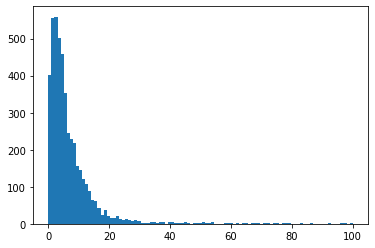

In [28]:
bins=np.linspace(0,100,100)
plt.hist(df['reply_time'],bins)
plt.show()

In [29]:
bins=np.linspace(0,15,30)
plt.hist(df[df.has_reply==True]['punct'],bins, alpha=0.5, normed=True, label='Urgent')
plt.hist(df[df.has_reply==False]['punct'],bins, alpha=0.5, normed=True, label='Non-Urgent')
plt.legend(loc='upper right')
plt.show()

KeyError: 'punct'

In [30]:
df.reply_time.describe()

count    4722.000000
mean       28.329310
std       192.423197
min         0.000000
25%         3.000000
50%         5.000000
75%        10.000000
max      4435.000000
Name: reply_time, dtype: float64

In [31]:
df[df["reply_time"]>0].reply_time.describe()

count    4651.000000
mean       28.761772
std       193.854584
min         1.000000
25%         3.000000
50%         5.000000
75%        10.000000
max      4435.000000
Name: reply_time, dtype: float64

### Tweet length

In [32]:
df['length']=df['raw'].apply(lambda x:len(x)-x.count(" "))

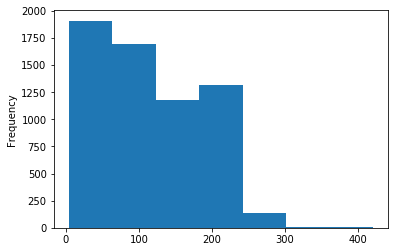

In [33]:
df.length.plot.hist(bins=7)

### Punctuation percentage

In [34]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100

df['punct']=df['raw'].apply(count_punct)

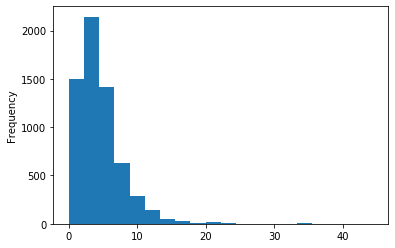

In [35]:
df.punct.plot.hist(bins=20)

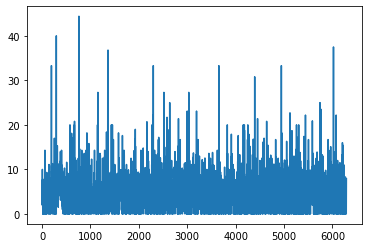

In [36]:
plt.plot(df.punct)

In [37]:
df.punct.describe()

count    6248.000000
mean        4.506466
std         3.549013
min         0.000000
25%         2.300000
50%         3.900000
75%         5.900000
max        44.400000
Name: punct, dtype: float64

### Direct mention of brand in tweet

In [38]:
df["direct_mention"] = df["raw"].apply(lambda x: "@AmazonHelp" in x)

In [39]:
df.direct_mention.value_counts()

False    4587
True     1661
Name: direct_mention, dtype: int64

### Sentiment analysis of tweet

In [40]:
##SENTIMENT ANALYSIS

text = "Literally about to cancel Amazon Prime. Pretty much the only reason being the removal of Seinfeld! Sorry @primevideouk @AmazonHelp"
text = "I love that"

opinion = TextBlob(text, analyzer=NaiveBayesAnalyzer())
opinion.sentiment
opinion.sentiment.classification == 'pos'

True

In [41]:
tqdm.pandas()
analyzer=NaiveBayesAnalyzer()
df["positive_sentiment"] = df["raw"].progress_apply(lambda x:  TextBlob(x, analyzer=analyzer).sentiment.classification == 'pos')

/home/victor/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [42]:
df.positive_sentiment.value_counts()

True     3638
False    2610
Name: positive_sentiment, dtype: int64

### Upsampling / Downsampling 

In [17]:
count_class_false, count_class_true = df['has_reply'].value_counts()
print(count_class_true, count_class_false)
count_class=min(count_class_true, count_class_false)

# Divide by class
df_class_true = df[df['has_reply'] == True]
df_class_false = df[df['has_reply'] == False]

df_class_false_under = df_class_false.sample(count_class)
df_class_true_under = df_class_true.sample(count_class)
df = pd.concat([df_class_false_under, df_class_true_under], axis=0)

count_class_false, count_class_true = df['has_reply'].value_counts()
print(count_class_true, count_class_false)

1534 4756
1534 1534


# 4. Models

# 4A. Final pre-processing

In [43]:
df = preprocess(df)

In [44]:
len(df)

6248

In [45]:
get_frequent_words(df.clean_tweet)

{'You',
 'account',
 'amazon',
 'amazonhelp',
 'amazonin',
 'call',
 'customer',
 'day',
 'deliver',
 'delivery',
 'email',
 'get',
 'help',
 'issue',
 'order',
 'please',
 'product',
 'say',
 'service',
 'time'}

# 4B. Vectorization

###  1. Bag Of Words

In [46]:
def bow_encode(text):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    print("Vocab size is: ", len(vectorizer.get_feature_names()))
    return X

In [47]:
np.unique(bow_encode(df.clean_tweet).toarray())

Vocab size is:  8297


array([0, 1, 2, 3, 4, 5, 6])

#### Visualize Bag Of Words

Vocab size is:  8297


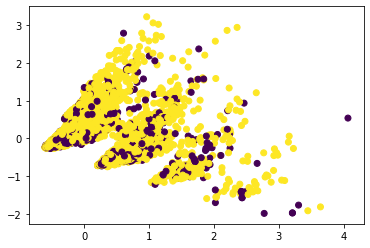

In [48]:
X = bow_encode(df.clean_tweet).todense()
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=df.has_reply)

### 2. Tf IdF 

In [49]:
def tfidf_encode(text):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
    return tfidf_vectorizer.fit_transform(text)

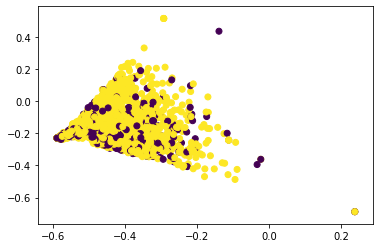

In [50]:
Z = tfidf_encode(df.clean_tweet).todense()
pca = PCA(n_components=2).fit(X)
Z_data2D = pca.transform(Z)
plt.scatter(Z_data2D[:,0], Z_data2D[:,1], c=df.has_reply)

### 3. Word2vec

In this section, we load a pre-trained model (GloVe or Google Word2Vec), and generate and store the embeddings of all the tweets.
Caution : the model needs to be downloaded before

#### Google Word2Vec loading

In [51]:
model_path = "../../source/embeddings/GoogleVectors300d/GoogleNews-vectors-negative300.bin"
binary = True
storage_folder = "../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GoogleVectors300d/"

#### GloVe loading

In [52]:
model_path = "../../source/embeddings/GloveTwitter200d/glove.twitter.27B.200d.txt"
binary = False
storage_folder = "../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GloveTwitter200d/"

#### Load model

In [ ]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=binary)

#### Create embeddings and save to CSV

In [215]:
text_features = pd.DataFrame() # creating empty final dataframe
stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in tqdm(df.clean_tweet): # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc.split(' '): # looping through each word of a single document and spliting through space
        if word not in stopwords: # if word is not present in stopwords then (try)
            try:
                word_vec = embeddings[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    text_features = text_features.append(doc_vector, ignore_index = True) # append each document value to the final dataframe

text_features.to_csv(storage_folder+brand+".csv",)
text_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.068341,0.055734,-0.017373,0.044397,-0.059613,0.050806,0.004077,-0.017065,0.075073,0.120728,-0.093079,-0.144580,-0.057751,0.015302,-0.123718,0.144336,0.067236,0.074517,-0.090036,-0.148145,0.039056,-0.039786,0.070895,0.081412,-0.051093,-0.002045,-0.071160,0.079883,-0.031934,-0.072662,-0.020464,-0.011035,-0.065335,-0.054572,-0.044153,0.034351,0.017149,0.061523,0.023877,0.020154,0.024023,0.002490,0.081714,0.000391,-0.043896,-0.210217,0.061670,-0.027524,-0.065997,-0.048460,-0.064532,0.048584,0.036502,-0.043213,0.068262,-0.037157,-0.100354,-0.103072,-0.007990,-0.098535,0.041466,0.000049,-0.144983,0.002646,-0.064191,-0.118542,-0.102417,0.040637,-0.022205,0.027493,0.028775,0.057529,0.035315,0.018834,-0.083058,-0.094916,0.037488,0.098804,0.041956,0.083286,-0.059766,0.039609,0.062979,-0.007092,0.038519,-0.025140,-0.162744,0.127206,-0.031317,0.061484,0.067749,0.044849,-0.005170,-0.022992,-0.022818,-0.058997,0.052063,0.121759,0.166296,0.023322,-0.027161,0.082732,0.026343,-0.027441,0.014832,-0.028036,-0.060504,-0.051273,0.101471,-0.119153,-0.002173,-0.050636,0.006897,-0.009094,0.070991,-0.014014,0.029639,-0.071497,0.023236,0.010178,-0.033765,-0.045721,-0.089370,0.002881,-0.068713,0.016919,-0.120337,0.020020,0.053290,0.037488,-0.170898,-0.045972,-0.038260,0.088869,-0.030843,0.004007,0.016442,-0.019897,-0.032776,0.023999,0.125250,-0.063794,-0.011401,-0.036984,-0.034875,-0.075000,-0.080396,-0.005444,-0.025195,-0.117792,0.201392,0.001765,-0.117398,0.001424,-0.072350,-0.083755,0.015704,-0.037329,-0.056848,-0.061829,0.030359,0.027087,0.020117,0.015898,-0.014728,-0.124939,0.043976,-0.108569,-0.048490,0.053857,-0.089059,-0.001318,-0.018036,-0.012085,0.003687,0.051562,0.146497,-0.171875,0.048340,-0.016345,-0.033198,0.001587,-0.063443,0.023772,-0.032745,0.042456,-0.140356,0.012141,0.060422,0.040277,0.055859,-0.017688,0.064990,-0.009161,0.023706,0.151758,0.052966,-0.079422,-0.056155,-0.088672,-0.028503,0.093750,-0.082452,-0.058679,-0.022424,-0.022687,-0.091957,0.002588,-0.034204,0.056323,-0.029855,0.011719,-0.053381,0.069141,-0.136572,-0.003979,0.136475,-0.006769,0.045398,0.016418,-0.042761,0.028963,0.062933,0.101819,0.056921,-0.032081,0.065948,-0.003628,-0.019809,-0.029425,0.002132,0.013290,0.018756,-0.050659,0.048326,0.053961,0.011444,0.070215,0.100208,0.083008,0.098804,0.067334,0.070715,-0.088373,-0.012283,0.021460,-0.066257,0.169775,-0.042993,-0.065723,0.071814,0.009985,-0.038843,0.128925,0.132031,-0.153711,-0.048450,0.056384,0.000415,-0.099969,-0.003128,0.016479,0.049182,0.003503,0.071118,0.110382,-0.010999,-0.035004,-0.100946,-0.049304,-0.022610,0.081934,0.089160,0.013351,0.100043,-0.053680,-0.019403,-0.103833,-0.029161,0.089246,-0.004484,-0.049146,0.015479,0.112061,-0.075684,-0.042945,-0.120801,0.019775,-0.025403,-0.059552,0.004413,0.124463,-0.063049,0.096151,-0.099756,-0.065771,-0.051367,-0.128943,-0.026352,-0.006451
1,0.081652,0.011393,0.030782,0.044159,-0.024816,0.0

### Final function to vectorize (build text features)

In [53]:
def build_text_features(df, vect_type):
    
    logging.info("Extracting features and creating vocabulary...")

    new_df = df[['nb_tweets_of_user', 'following', 'followers', 'likes','direct_mention', 'punct', 'length', 'positive_sentiment', 'clean_tweet']]
    for col in new_df.columns:
        if col != "clean_tweet":
            new_df[col]=new_df[col].apply(lambda x: 0 if np.isnan(x) else int(x))
        
    if "word2vec" in vect_type:
        if "google" in vect_type:
            text_features = pd.read_csv("../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GoogleVectors300d/"+brand+".csv", index_col=0)
        
        if "glove" in vect_type:
            text_features = pd.read_csv("../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GloveTwitter200d/"+brand+".csv", index_col=0)

        # Remove nan values in text features
        for col in text_features.columns:
            text_features[col]=text_features[col].apply(lambda x: 0 if np.isnan(x) else x)
        
        new_df.drop(columns="clean_tweet", inplace=True)
        X = pd.merge(text_features, new_df, left_index=True, right_index=True)
        y = df.has_reply

        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,random_state=44)

    else:
        y = df.has_reply
        X_train, X_test, y_train, y_test = train_test_split(new_df,y,train_size=0.80,random_state=44)

        field = 'clean_tweet'
   
        if 'count' in vect_type:
            vectorizer= CountVectorizer(binary=False, max_df=0.95)
        
        elif "binary" in vect_type:
            vectorizer= CountVectorizer(binary=True, max_df=0.95)

        elif 'tfidf' in vect_type:
            vectorizer=TfidfVectorizer(max_features = 3000, use_idf=True, max_df=0.95)
        #add n-gram
        
        else:
            raise ValueError('Mode should be either count or tfidf')
            
        # Fit on training data
        vectorizer.fit_transform(X_train[field].values)
        
        train_text_features=vectorizer.transform(X_train[field].values).toarray()
        test_text_features=vectorizer.transform(X_test[field].values).toarray()
        
#         for col in text_features.columns:
#             text_features[col]=text_features[col].apply(lambda x: 0 if np.isnan(x) else x)
    
        X_train.drop(columns=['clean_tweet'], inplace=True)
        X_test.drop(columns=['clean_tweet'], inplace=True)

        X_train=np.concatenate((X_train,train_text_features),axis=1)
        X_test=np.concatenate((X_test,test_text_features),axis=1)
    
    return X_train, X_test, y_train, y_test   

# 4C. Model evaluation

### All scores

In [54]:
## PRINT SCORES

def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_val = f1_score(y_test, y_pred)
    precision_score_val = precision_score(y_test, y_pred)
    recall_score_val = recall_score(y_test, y_pred)


    string = "RESULTATS \n \
    Accuracy  : {accuracy}% \n \
    F1 score  : {f1_score}\n \
    Precision : {precision}% (how many selected items are relevant)\n \
    Recall    : {recall}% (how many relevant items are selected)\n \
    \n\n\
    STATISTICS\n\
     Proportion of positives in test set    : {positives}%\n\
     Proportion of positives in predictions : {predicted_positives}%\
    "

    print(string.format(accuracy = round(100*accuracy,2),
                        f1_score = round(f1_score_val,4), 
                        precision = round(100*precision_score_val,2), 
                        recall = round(100*recall_score_val,2),
                        positives = round(100*y_test.sum()/len(y_test),2),
                        predicted_positives = round(100*y_pred.sum()/len(y_pred),2),
                       ))

### ROC Curve & AUC 

In [55]:
## DISPLAY ROC CURVE
def display_roc_curve(y_test, X_test, model):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_score = round(auc(fpr, tpr),2)

    plt.plot(fpr, tpr, color='darkorange',
             lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC : {}".format(auc_score))

### Confusion matrix 

In [56]:
# CONFUSION MATRIX
def get_confusion_matrix(X_test, y_test, model):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)


### Feature importance 

In [57]:
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()

In [58]:
# Compile arrays of columns (words) and feature importances
fi = {'Words':df.columns.tolist(),'Importance':model.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 20
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

# Plot the graph!
titles = ["Top 25 most important words in predicting product recommendation"]
importance_plotting(Importance,'Importance','Words','Greens_r',titles)

NameError: name 'model' is not defined

In [59]:
features = pd.DataFrame()
features['importance'] = rf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.head()
from sklearn import metrics
features.plot(kind='barh', figsize=(10, 8))
plt.title('Most important features')
plt.show()

NameError: name 'rf' is not defined

# 5. Choose, train & test model

In [60]:
def try_model(model, encode_type, df):
  
    print("Building the features...")
    X_train,X_test,y_train, y_test = build_text_features(df,encode_type)
    
    print("Training the model...")
    clf = model.fit(X_train,y_train)
    
    print("Making predictions...")
    y_preds = clf.predict(X_test)
    
    print("Printing scores...")
    print(classification_report(y_test, y_preds))
    print_scores(y_test,y_preds)
    display_roc_curve(y_test,X_test, model)
    get_confusion_matrix(X_test, y_test, model)
    
    return y_test, y_preds

## Pipeline

In [61]:
df = preprocess(df)

In [68]:
#model = LogisticRegression()
#model = MultinomialNB()
#model = RandomForestClassifier()
model = RandomForestClassifier(n_estimators=200, verbose=1, n_jobs=4, class_weight={False: 0.9, True: 0.1})
#model =xgb.XGBClassifier(random_state=42,learning_rate=0.01)
#model = LinearSVC()

#encode_type = "count"
#encode_type = "tfidf"
encode_type = "binary"
#encode_type = "word2vec_glove"
#encode_type = "word2vec_google"

Building the features...


/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Training the model...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   14.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Making predictions...


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Printing scores...
              precision    recall  f1-score   support

       False       0.65      0.24      0.35       294
        True       0.80      0.96      0.88       956

    accuracy                           0.79      1250
   macro avg       0.73      0.60      0.61      1250
weighted avg       0.77      0.79      0.75      1250

RESULTATS 
     Accuracy  : 79.04% 
     F1 score  : 0.8751
     Precision : 80.39% (how many selected items are relevant)
     Recall    : 96.03% (how many relevant items are selected)
     

    STATISTICS
     Proportion of positives in test set    : 76.48%
     Proportion of positives in predictions : 91.36%    


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


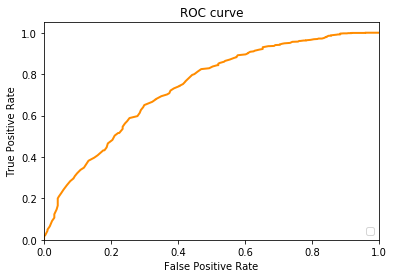

AUC : 0.74


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Confusion matrix, without normalization
[[ 70 224]
 [ 38 918]]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Normalized confusion matrix
[[0.23809524 0.76190476]
 [0.03974895 0.96025105]]


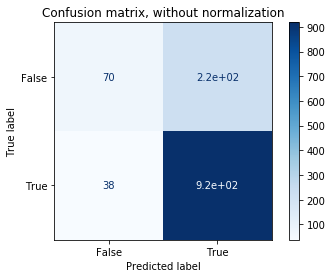

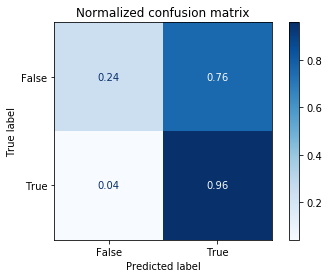

In [69]:
y_test, y_preds = try_model(model, encode_type, df)

## Samples 

In [ ]:
#SAMPLES DE TOUTES LES CATEGORIES

##on recupere les tweets urgents manqués

#urgents and not urgents tweets index
positives = y_test[y_test==True].index
negatives = y_test[y_test==False].index

#correct and incorrect predictions index
is_prediction_correct = y_test==y_preds
correct_predictions   = is_prediction_correct[is_prediction_correct==True].index
incorrect_predictions = is_prediction_correct[is_prediction_correct==False].index

#true/false positive/negative index
true_positive_index  = correct_predictions.intersection(positives)
true_negative_index  = correct_predictions.intersection(negatives)
false_positive_index = incorrect_predictions.intersection(negatives)
false_negative_index = incorrect_predictions.intersection(positives)

In [176]:
df.loc[true_positive_index][['raw']]

,raw
4981,I already called. That's how I know your one way verification is horrible.
5932,"Waiting for resolution, when you will refund my money.pickup person name is sanjay,and I already provide him wrong product 4 days ago, please contact to your delivery support team.\nI request you to resolve this issue ASAP."
5661,For delivery already call and update regards this. But your delivery Hub reverse and purposes fully dely the delivery so we need only my product today if you are not arrange the delivery nd support your hub no need this product
3099,I received the email and I just told you about the resolution your team provided. It was unsatisfactory and did not solve the problem. I cannot respond to that mail in case you don’t know - your customer care model doesn’t allow for that.
5558,"DP is irritated. He says he is hungry and tired. Believing that station will receive the mail since AP said so, I take pity on DP and send him back with the book and ask him to return it tomorrow when they have received the mail and everything is sorted (6)"
...,...
4624,"I got an email saying “We would appreciate if you can elaborate your inquiry and provide more specific information, by contacting us from registered mobile number” like I told you, it’s not my account and it’s not my mobile number. If it was I would have reset the password myself"
859,"It is not about cashback, issue regarding upi transaction"
5658,Appstore for iPhone
5603,@AmazonHelp is it normal for call back to take 40 minutes plus - thats how long Ive been waiting?


In [177]:
df.loc[true_negative_index][['raw']]

,raw
392,Because they’ve not heart and removed it 😢 @AmazonHelp https://twitter.com/rishie_/status/1223002528876503044 …
402,Such a joke @AmazonHelp bring back Alicia Florrick into our lives. https://twitter.com/binnsy29/status/1223342725417840640 …
2929,"Sadly this is just one of Amazon’s automated stock responses that they’ve sent thousands of times. There’s no sign that the packaging feedback is being reviewed at all, they just send these as they want customers to think they’re being heard"
194,Sure :)
2634,Wish to win😀\n#AmazonPayKYCQuiz\n@AmazonHelp\n@Amazonquiztime\n@amazonIN\n@drarpita92 pic.twitter.com/A7U9AUgzG2
4733,Wasn't very helpful. For a billion dollar company you would think us artist could at least be paid ON TIME.. I'm sure it's all automatically done and not human error but imagine your paycheck not coming on time.. I'm sure you'd be annoyed at the inconvenience.
3566,"Be aware that #AmazonWardeobe is impossible to use for anything but cheap items because there is a secret £100 limit that you don't find out about until after you waste your evening filling your basket. Possibly still useful for cheap items. Thanks @AmazonHelp for trying, anyway. https://twitter.com/RobFisher/status/1224063768705093632 …"
642,". @SmartHomes__ . @ShieldVoC RT @SmartHomes__: . @MoodySlayerUK @AmazonHelp Base ball season starts soon, any chance to official MLB Ale..."
4592,Define irony: #StarTrek was built on the notion that humanity is now enlightened. Broadcasters ignore disabled viewers' basic needs. 🙄
399,Come on @AmazonHelp do something about it. https://twitter.com/ainemorriss/status/1223052574930165761 …


In [178]:
df.loc[false_positive_index][['raw']]

,raw
6077,Yes sure :)
3722,You shouldn't even be using this type of packaging #WarOnPlastic Does Amazon even realise the state of our planet!
3508,All posts are about the item purchased and my feelings after using it
4643,@AmazonHelp when is the digital release of sarileru neekevaru
3291,Update - still no contact from @AmazonHelp
1139,"Hi, I’ll DM you now. I tried the ‘call me’ function earlier which didn’t work and I’m not downloading the app for a web chat"
4108,@amazon @AmazonHelp \nAmazon search listing wrong entries. Request to rectify pic.twitter.com/GHkn6W9S2q
4866,"I’m glad you got the team to help you out because so far, the show it’s included on the membership.\nHope the issue gets resolved soon! \nChuck is very important to us!"
2111,"Yes multiple times, they have hit walls unlocking and kept trying the same steps over and over. They told me just to start a new account. Then I lose my prime paid days, all my movies and tv shows I bought and will not be able to access my wedding registry!"
6089,"@AmazonHelp 100% kadhal movie release today or tomorrow..\nI am a prime video member..pls don't ignore my request....also i want iruttu,naan avalai sanditha podhu movie"


In [179]:
df.loc[false_negative_index][['raw']]

,raw
2272,Sent.
5283,I get that. Can you please reconsider and put it back on Prime. That's all.
2671,"Yes, I am waiting on a delayed package. No, the tracking info doesn't indicate the carrier. I'm just saying maybe it's time to stop using the phrase ""Guaranteed delivery"" and opt for something more reasonable."
4160,"@AmazonHelp She denied me a supervisor citing that she knows everting and a supervisor will not do anything, it is kust not the matter of 20 bucks it is the matter of principles, if I have missed the lightening deal by few seconds you should not penalize me by with delvry charges"
6004,"@AmazonHelp 𝙏𝙃𝙀𝙔 𝘿𝙄𝘿𝙉'𝙏 𝙏𝘼𝙆𝙀 𝙊𝙉𝙀 𝙊𝙁 𝙏𝙃𝙀 𝙍𝙀𝙋𝙇𝘼𝘾𝙀𝙈𝙀𝙉𝙏. 𝘽𝙐𝙏 𝙏𝙃𝙀 𝘿𝙄𝘿 𝙏𝘼𝙆𝙀 𝘼 𝘿𝙀𝙇𝙄𝙑𝙀𝙍𝙔 𝙋𝙃𝙊𝙏𝙊 𝙊𝙁 𝘾𝙀𝙇𝙇𝙋𝙃𝙊𝙉𝙀 𝙋𝙍𝙊𝙏𝙀𝘾𝙏𝙄𝙊𝙉 , 𝘽𝙊𝙏𝙃 𝙐𝙉𝘿𝙀𝙍 10 𝘿𝙊𝙇𝙇𝘼𝙍𝙎. 𝙒𝙃𝙀𝙉 𝙏𝙃𝙀𝙔 𝙎𝙀𝙉𝙏 𝙊𝙐𝙏 𝙏𝙃𝙀"
2797,Yo @AmazonHelp why tf is my package half open you trifling ass bitch I sure as fuck didn’t do that pic.twitter.com/jkkXCeGgdg
2331,Almost feel ashamed posting it out on twitter.\n\nFirst kinda did it as a joke about how terrible Hermes are. Little did I expect Amazon to take so little ownership of the problem they created. 😢
4601,@AmazonHelp Please Provide Me Prime Link Of #athadesrimannarayana..\n\n@PrimeVideo
5653,It's not my concern. Hoping you also notice Everybody has a doubt about your Daily Quiz. Nobody knows where all these prizes go. There is no clarity about your quiz contest. You have follow Samsung contest. Everybody knows who gets their prizes. But you have darkness in your quiz
6073,"Agent was ineffective at resolving the issue, but not her fault, she had been disempowered. And what's with the heinous new phone tree?? Took 5+ minutes just to get to a human being. The fault is with the system, not your agents."


# 6. Save Model